# <u>Predicting Obesity Status in Mexico: A Machine Learning Approach </u>
*An analysis of dietary, lifestyle, and demographic factors using classification models*

This dataset is sourced from the UC Irvine Machine Learning Repository and comprises 2,111 observations with 17 attributes describing individuals from Mexico used to estimate obesity levels based on dietary habits and physical condition. Of the data, 23% was collected directly from users via a web platform, while the remaining 77% was synthetically generated using the Weka tool and SMOTE filter.

## <u>Functions</u>

In [2]:
def get_results(actual, predicted):
    '''
    Takes the actual and predicted values for a model 
    and prints a confusion matrix, and returns the following metrics: 
    accuracy, recall, precision, F1-score.
    '''
    
    print("The confusion matrix for your predictions is:")
    cm = metrics.confusion_matrix(actual, predicted)
    
    # Plot confusion matrix
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    
    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(ax=ax, cmap='RdYlBu', colorbar=False, text_kw={'color': 'black', 'fontsize': 10})
    ax.set_title("Confusion Matrix", fontsize=14, fontweight='bold', pad=12)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    plt.tight_layout()
    plt.show()

    print(f'Accuracy: {metrics.accuracy_score(actual, predicted):.3f}')
    
   # Macro averaging treats all classes equally, regardless of imbalance
    print(f'Recall (macro): {metrics.recall_score(actual, predicted, average="macro"):.3f}')   # each class recall equally weighted
    print(f'Precision (macro): {metrics.precision_score(actual, predicted, average="macro"):.3f}') # avoids dominance of majority class
    print(f'F1-score (macro): {metrics.f1_score(actual, predicted, average="macro"):.3f}')

## <u>Importing Data and Libraries</u>

In [3]:
# Core libraries
import numpy as np
import pandas as pd
import warnings

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Modelling 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [4]:
# Import dataset and save to dataframe 'obesity' (obesity data set)
obesity = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")

## <u> Initial Data Cleaning </u>

#####  <u> Data Inspection </u>

In [5]:
# Displaying all columns in the data
pd.set_option('display.max_columns', None)

# Initial look-over
obesity.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [6]:
# Displays the number of observations (rows) and variables (columns) in the obesity dataset
obesity.shape

(2111, 17)

##### <u> Column Renaming </u>

In [7]:
#Rename columns
obesity.rename(columns={'Gender':'gender',
                   'Age':'age',
                   'family_history_with_overweight':'family_overweight_history',
                   'FAVC':'high_caloric_diet', 
                   'FCVC':'vegetable_consumption_frequency',
                   'NCP' : 'daily_meal_frequency', 
                   'CAEC' : 'snack_consumption',
                   'SMOKE' : 'smoking_status',
                   'CH2O' : 'water_intake_frequency',
                   'SCC' : 'monitors_daily_calories',
                   'FAF' : 'physical_activity_frequency',
                   'TUE' : 'daily_time_using_technology',
                   'CALC' : 'alcohol_consumption',
                   'MTRANS' : 'transportation_mode',
                   'NObeyesdad':'obesity_category' }, 
                   inplace=True)

> Variables were **renamed** to clarify each column’s purpose and ensure consistency with coding standards.

##### <u> Checking For Nulls </u>

In [8]:
obesity.isnull().sum()

gender                             0
age                                0
Height                             0
Weight                             0
family_overweight_history          0
high_caloric_diet                  0
vegetable_consumption_frequency    0
daily_meal_frequency               0
snack_consumption                  0
smoking_status                     0
water_intake_frequency             0
monitors_daily_calories            0
physical_activity_frequency        0
daily_time_using_technology        0
alcohol_consumption                0
transportation_mode                0
obesity_category                   0
dtype: int64

> There are **no null** values in any columns, the next step is to check for zero values, which may indicate missing or improperly recorded data.

##### <u> Checking for Zeros </u>

In [9]:
(obesity == 0).sum() 

gender                               0
age                                  0
Height                               0
Weight                               0
family_overweight_history            0
high_caloric_diet                    0
vegetable_consumption_frequency      0
daily_meal_frequency                 0
snack_consumption                    0
smoking_status                       0
water_intake_frequency               0
monitors_daily_calories              0
physical_activity_frequency        411
daily_time_using_technology        557
alcohol_consumption                  0
transportation_mode                  0
obesity_category                     0
dtype: int64

> Zeros in the `physical_activity_frequency` and `daily_time_using_technology` columns are valid and meaningful, representing no activity or technology use, so these observations will be **retained** in the dataset.

##### <u> Checking for Duplicates </u>

In [11]:
# Sum the number of duplicate rows in the obesity dataframe
# We find that there are 24 duplicates 
obesity.duplicated().sum()

np.int64(24)

> There are 24 **duplicate observations** in the dataset, which will be removed. Although some individuals may naturally have identical values for features like `smoking_status` and `gender`, these observations are removed because exact duplicates across all variables are extremely unlikely and could **introduce bias**.

In [14]:
#removing the duplicates 
obesity = obesity.drop_duplicates()
#ensure none still remain 
obesity.duplicated().sum()

np.int64(0)

##### <u> Checking Data Types </u>

In [15]:
# Check the data types of all columns to ensure they are numeric (int / float)
print(obesity.dtypes)
#make a copy to do feature engeneering on.
obesitydf=obesity.copy()

gender                              object
age                                float64
Height                             float64
Weight                             float64
family_overweight_history           object
high_caloric_diet                   object
vegetable_consumption_frequency    float64
daily_meal_frequency               float64
snack_consumption                   object
smoking_status                      object
water_intake_frequency             float64
monitors_daily_calories             object
physical_activity_frequency        float64
daily_time_using_technology        float64
alcohol_consumption                 object
transportation_mode                 object
obesity_category                    object
dtype: object


> Object predictor variables will need to be **transformed** into **numeric data types**. The dependent variable `obesity_category` can remain as an object, as it is the categorical target.

##### <u> Binary Variable Transformations </u>

In [16]:
# Mapping 'Male' and 'Female', and 'no' and 'yes' into binary 0s and 1s
# Also converting the data type to ensure these columns are integers instead of objects
obesitydf.gender = obesitydf.gender.map({'Male':0, 'Female':1}).astype(int)
obesitydf.family_overweight_history  = obesitydf.family_overweight_history.map({'no':0, 'yes':1}).astype(int)
obesitydf.high_caloric_diet  = obesitydf.high_caloric_diet.map({'no':0, 'yes':1}).astype(int)
obesitydf.smoking_status = obesitydf.smoking_status.map({'no':0, 'yes':1}).astype(int)
obesitydf.monitors_daily_calories  = obesitydf.monitors_daily_calories.map({'no':0, 'yes':1}).astype(int)

>The categorical predictor variables have been **transformed** into binary **numeric variables**.

##### <u> One-Hot Encoding of Categorical Variables </u>

In [14]:
# Convert the categorical columns 'snack_consumption', 'alcohol_consumption', and 'transportation_mode' into dummy variables 
#dropping the first category to avoid multicollinearity and using integer type for the encoded values
obesitydf= pd.get_dummies(obesitydf, columns=['snack_consumption','alcohol_consumption','transportation_mode'], drop_first=True, dtype=int)
obesitydf= pd.get_dummies(obesitydf, columns=['snack_consumption','alcohol_consumption','transportation_mode'], drop_first=True, dtype=int)

> The selected categorical variables were **one-hot encoded** into binary columns, with the first category dropped to prevent **multicollinearity**, preparing the dataset for machine learning models.

##### <u> Target Variable Grouping </u>

In [27]:
# Consolidate weight categories into broader classes for classification
y_train = y_train.replace({
    'Obesity_Type_I': 'Obese',
    'Obesity_Type_II': 'Obese',
    'Obesity_Type_III': 'Obese',
    'Overweight_Level_I': 'Overweight',
    'Overweight_Level_II': 'Overweight',
    'Normal_Weight': 'Under/Normal Weight',
    'Insufficient_Weight': 'Under/Normal Weight'})

To address class imbalance and improve model performance, the original seven obesity categories were consolidated into three groups: `Under/Normal Weight`, `Overweight`, and `Obese`, combining similar health categories and ensuring enough samples per class.

## <u> Test Train Split </u>

In [29]:
# The feature columns are all columns except 'obesity_category'
# So we drop this column and save as a new dataframe, X

X = obesitydf.drop(['obesity_category'], axis=1)

# The target column in 'obesity_category'
y = obesitydf['obesity_category']

#y is discreate caegoricl data (no need for bins =y)
y_strat = y

# Perform the split and assign to the corresponding variables
# stratify=y_strat ensures each obesity class keeps the same proportion in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100, stratify= y_strat)

> There are 2,111 observations, so an 80/20 split provides enough data for the model to learn patterns while still reserving a meaningful test set. **Stratifying** ensures that even the less common obesity classes are represented proportionally in both sets (X,y), preventing infrequent categories from being under/over represented in either split.

## <u> Scaling </u>

In [30]:
X_train_scaled = X_train.copy()

# Initialise RobustScaler
rob = RobustScaler()

# Select only the TRUE numerical features
rob_features = [
    'physical_activity_frequency',
    'daily_time_using_technology'
]

# Fit and transform
X_train_scaled[rob_features] = rob.fit_transform(X_train_scaled[rob_features])

> The numerical features `physical_activity_frequency` and `daily_time_using_technology` were scaled using `RobustScaler` to reduce the impact of outliers while preserving their distribution.

## <u> Feature Exploration </u>

#### <u>Exploring Key Features</u>

#### <u>Activity Levels Across Obesity Categories</u>

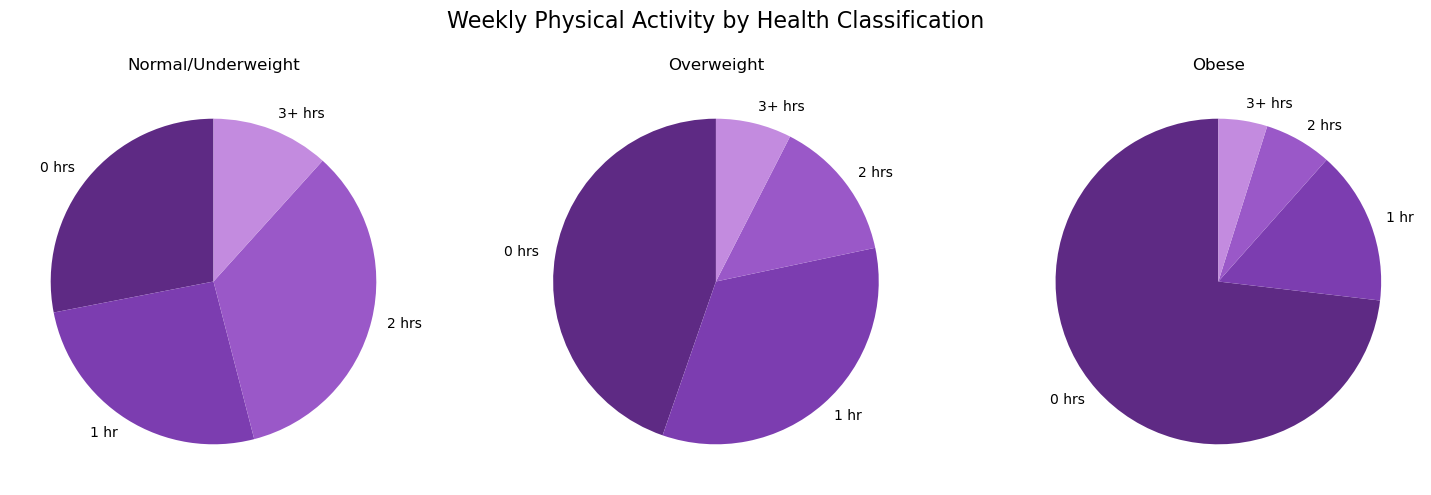

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

obesitydf['obesity_category'] = obesitydf['obesity_category'].replace({
    'Obesity_Type_I':'Obese',
    'Obesity_Type_II':'Obese',
    'Obesity_Type_III':'Obese',
    'Overweight_Level_I':'Overweight',
    'Overweight_Level_II':'Overweight',
    'Normal_Weight':'Normal/Underweight',
    'Insufficient_Weight':'Normal/Underweight'
})

obesitydf_filtered = obesitydf[obesitydf['physical_activity_frequency'].isin([0,1,2,3])]

colors_map = {
    0: '#5E2A84',   # 0 hours – deep purple
    1: '#7C3DB0',   # 1 hour  – violet
    2: '#9A58C8',   # 2 hours – light violet
    3: '#C38BDF'    # 3+ hrs  – lavender
}

classes = obesitydf_filtered['obesity_category'].unique()

fig, axes = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Weekly Physical Activity by Health Classification', fontsize=16)

for i, cls in enumerate(classes):

    # Filter for this class
    df_class = obesitydf_filtered[obesitydf_filtered['obesity_category'] == cls]

    # Count number of people at each activity level
    counts = df_class['physical_activity_frequency'].value_counts().reindex([0,1,2,3], fill_value=0)

    # Labels without counts
    labels = ["0 hrs", "1 hr", "2 hrs", "3+ hrs"]

    # Colours
    colors = [colors_map[x] for x in counts.index]

    # Create pie chart
    axes[i].pie(counts, labels=labels, autopct=None, startangle=90, colors=colors)
    axes[i].set_title(cls)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

> Physical activity decreases as obesity category increases: nearly half of underweight/normal participants meet 2+ hours per week, while most overweight and obese participants are inactive, with fewer than 10% of obese individuals meeting WHO recommendations.

#### <u>Correlation Analysis</u>

In [21]:
selected_columns = (['gender', 'age', 'family_overweight_history',
       'high_caloric_diet', 'vegetable_consumption_frequency',
       'daily_meal_frequency', 'smoking_status', 'water_intake_frequency',
       'monitors_daily_calories', 'physical_activity_frequency',
       'daily_time_using_technology'])
corr_df = X_train_scaled[selected_columns]

In [43]:
# Calculate the correlation between all feature columns
# Except the one-hot-encoded ones
corr_matrix = corr_df.corr()

# Create a mask for the correlations which only shows correlations that
# are greater than 0.7 or smaller than -0.4.
mask1 = np.abs(corr_matrix) <= 0.3

# Create a mask which only shows the lower half of the matrix
mask2 = np.triu(corr_matrix) 

# Combine both masks
combined_mask = mask1|mask2

# Set the size of the graph
plt.figure(figsize=(8,8))

# Plot the correlation matrix on a heatmap
sns.heatmap(corr_matrix,
            vmin = -1,           # set the minimum value
            vmax = 1,            # set the maximum value
            annot=True,          # display correlation values
            mask=combined_mask,  # apply the combined mask
            cmap='YlGnBu')       # set the colour palette

# Add a title to the heatmap
plt.title("Pearson Coeffient > 0.3")

# Display
plt.show()

NameError: name 'corr_df' is not defined

#### <u> Variance Inflation Factors </u>

In [24]:
X = X_train_scaled
def calculate_vif(X, thresh = 7.0):
    '''
    List comprehension is used to gather all the VIF values of the different variables
    .index(max) gets the index of the highest VIF value and if above threshold is dropped
    Returns a list of variables that doesn't exceed the chosen threshold (of default 5)
    '''
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print("dropping " + X.iloc[:, variables].columns[maxloc] +
                  ' at index: ' + str(maxloc))
            del variables[maxloc] 
            dropped = True 

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

X_reduced = calculate_vif(X)

reduced_feature_cols = list(X_reduced)

dropping Height at index: 2
dropping alcohol_consumption_Sometimes at index: 16
dropping snack_consumption_Sometimes at index: 13
dropping Weight at index: 2
dropping vegetable_consumption_frequency at index: 4
dropping age at index: 1
dropping water_intake_frequency at index: 5
dropping daily_meal_frequency at index: 3
Remaining variables:
Index(['gender', 'family_overweight_history', 'high_caloric_diet',
       'smoking_status', 'monitors_daily_calories',
       'physical_activity_frequency', 'daily_time_using_technology',
       'snack_consumption_Frequently', 'snack_consumption_no',
       'alcohol_consumption_Frequently', 'alcohol_consumption_no',
       'transportation_mode_Bike', 'transportation_mode_Motorbike',
       'transportation_mode_Public_Transportation',
       'transportation_mode_Walking'],
      dtype='object')


> After calculating Variance Inflation Factors, highly collinear variables such as Height, Weight, Age, and certain dietary and alcohol frequency columns were dropped, leaving 15 features for modeling.

## <u> Feature Exploration </u>

#### <u> Logistic Regression </u>

In [26]:
# Intialise 
logreg = LogisticRegression()

# Train
model1 = logreg.fit(X_train[reduced_feature_cols], y_train)

The confusion matrix for your predictions is:


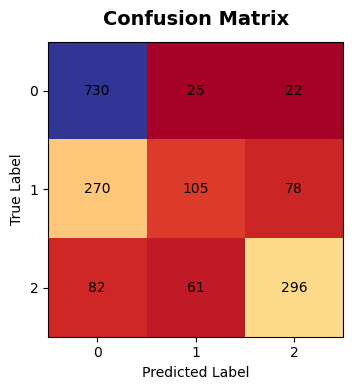

Accuracy: 0.678
Recall (macro): 0.615
Precision (macro): 0.657
F1-score (macro): 0.607


In [27]:
X_train_pred = model1.predict(X_train[reduced_feature_cols])

# Evaluate 
get_results(y_train, X_train_pred)

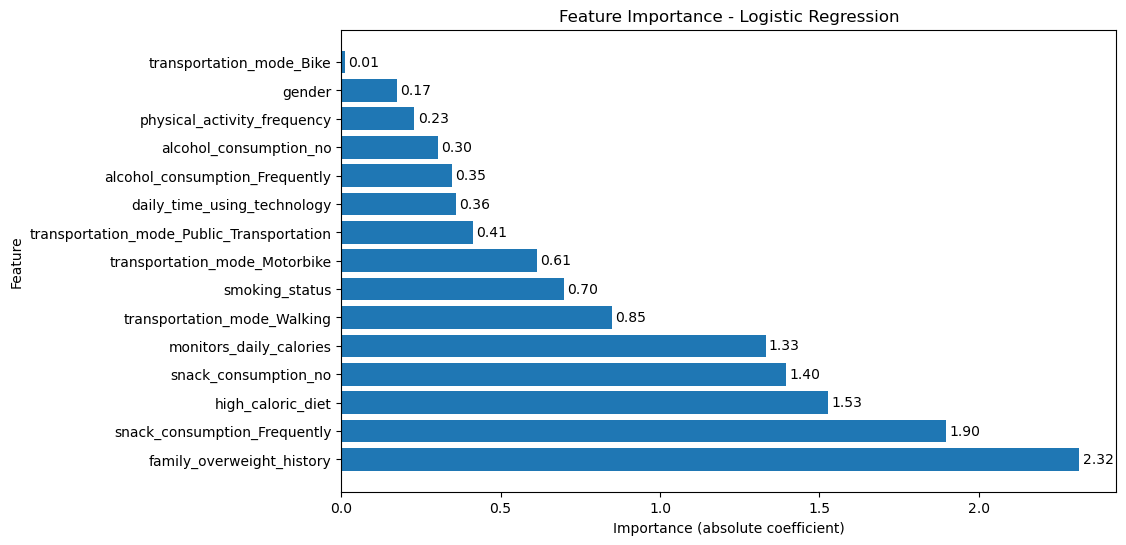

In [41]:
# Get absolute coefficients as importance
importances = np.abs(model1.coef_[0])

# Create a DataFrame for plotting (similar to your previous one)
import pandas as pd
feature_importances = pd.DataFrame({
    'feature': reduced_feature_cols,
    'importance': importances
}).sort_values(by='importance', ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(10,6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.gca().invert_yaxis()  # highest importance on top

# Add numbers at the end of each bar
for index, value in enumerate(feature_importances['importance']):
    plt.text(value + 0.01, index, f'{value:.2f}', va='center')

plt.xlabel('Importance (absolute coefficient)')
plt.ylabel('Feature')
plt.title('Feature Importance - Logistic Regression')
plt.show()

#### <u> Random Forest </u>

In [43]:
X_train.drop(columns =[ 'Weight','Height'], inplace = True)

In [44]:
# Intialise
rf = RandomForestClassifier(class_weight = 'balanced', random_state=42)

# Train
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [45]:
grid = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = {'max_depth': [5,6,7],
                                  'min_samples_split': [5, 10, 15],
                                  'min_samples_leaf': [2, 3, 4, 5, 6],
                                  'max_features':[1,6,7]}, #number of features to consider when looking at best split
                    cv = 10,
                    refit = True,
                    verbose = 2,
                    scoring = 'accuracy')

In [46]:
grid.fit(X_train, y_train)

# Assign the best estimator as our second model 
model2 = grid.best_estimator_
model2

Fitting 10 folds for each of 135 candidates, totalling 1350 fits
[CV] END max_depth=5, max_features=1, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=1, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=1, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=1, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=1, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=1, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=1, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=1, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=1, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=1, min_samples_lea

DecisionTreeClassifier(max_depth=7, max_features=7, min_samples_leaf=3,
                       min_samples_split=15)

In [47]:
model_to_save = grid.best_estimator_


The confusion matrix for your predictions is:


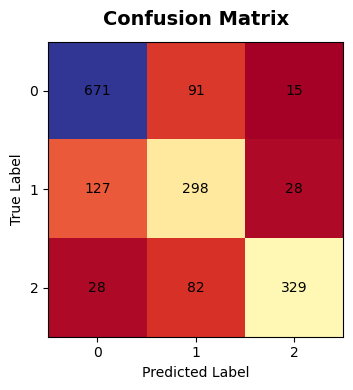

Accuracy: 0.778
Recall (macro): 0.757
Precision (macro): 0.776
F1-score (macro): 0.765


In [48]:
# Predict on training set
X_train_pred2 = model2.predict(X_train)
X_train_pred2
# Evaluate on training set 
get_results(y_train, X_train_pred2)

In [49]:
import pandas as pd

# Create a DataFrame of feature importances
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)


ValueError: All arrays must be of the same length

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.gca().invert_yaxis()  # highest importance on top

# Add numbers at the end of each bar
for index, value in enumerate(feature_importances['importance']):
    plt.text(value + 0.01, index, f'{value:.2f}', va='center')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Random Forest')
plt.show()


## <u> Obesity only, For Presentation </u>

Fitting 10 folds for each of 135 candidates, totalling 1350 fits
[CV] END max_depth=5, max_features=1, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=1, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=1, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=1, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=1, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=1, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=1, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=1, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=1, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, max_features=1, min_samples_lea

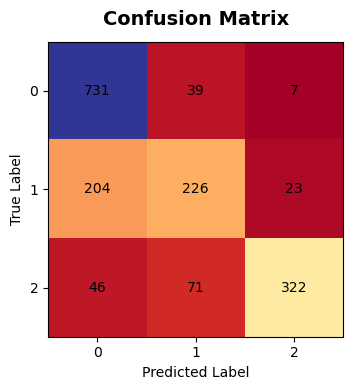

Accuracy: 0.766
Recall (macro): 0.724
Precision (macro): 0.778
F1-score (macro): 0.740


DecisionTreeClassifier(max_depth=7, max_features=7, min_samples_leaf=3,
                       min_samples_split=5)

In [51]:
# Drop columns
#X_train.drop(columns=['Weight','Height'], inplace=True)

# Train Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# GridSearchCV with DecisionTree
grid = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid={
        'max_depth': [5,6,7],
        'min_samples_split': [5,10,15],
        'min_samples_leaf': [2,3,4,5,6],
        'max_features':[1,6,7]
    },
    cv=10,
    refit=True,
    verbose=2,
    scoring='accuracy'
)
grid.fit(X_train, y_train)

# Assign the best estimator
model2 = grid.best_estimator_

# Make predictions on training set
X_train_pred2 = model2.predict(X_train)

# Evaluate
get_results(y_train, X_train_pred2)

# Inspect model
model2


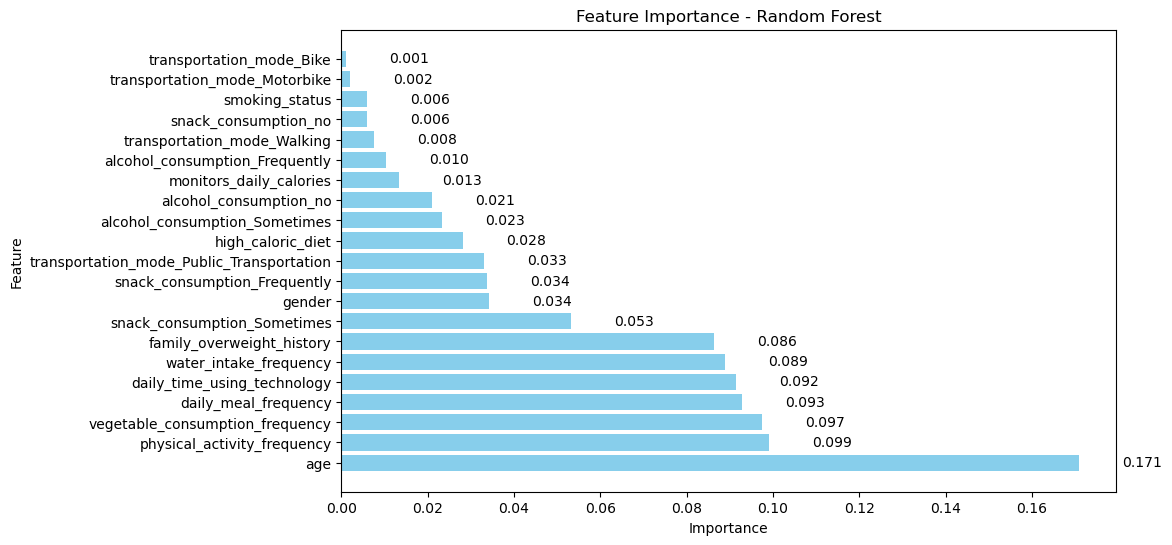

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create DataFrame of feature importances
feature_importances = pd.DataFrame({
    'feature': X_train.columns,           # columns after dropping Weight & Height
    'importance': rf.feature_importances_
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(10,6))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.gca().invert_yaxis()  # highest importance on top
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Random Forest')

# Add numbers at the end of each bar
for index, value in enumerate(feature_importances['importance']):
    plt.text(value + 0.01, index, f'{value:.3f}', va='center')

plt.show()


In [53]:
import pandas as pd

# Create DataFrame of feature importances
feature_importances = pd.DataFrame({
    'feature': X_train.columns,           # columns used in the model
    'importance': rf.feature_importances_
})

# Sort by importance (optional)
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Print feature importanceprint(feature_importances)

                                      feature  importance
1                                         age    0.170972
9                 physical_activity_frequency    0.099133
4             vegetable_consumption_frequency    0.097443
5                        daily_meal_frequency    0.092710
10                daily_time_using_technology    0.091512
7                      water_intake_frequency    0.088773
2                   family_overweight_history    0.086319
12                snack_consumption_Sometimes    0.053125
0                                      gender    0.034127
11               snack_consumption_Frequently    0.033830
19  transportation_mode_Public_Transportation    0.033126
3                           high_caloric_diet    0.028262
15              alcohol_consumption_Sometimes    0.023242
16                     alcohol_consumption_no    0.021066
8                     monitors_daily_calories    0.013348
14             alcohol_consumption_Frequently    0.010395
20            

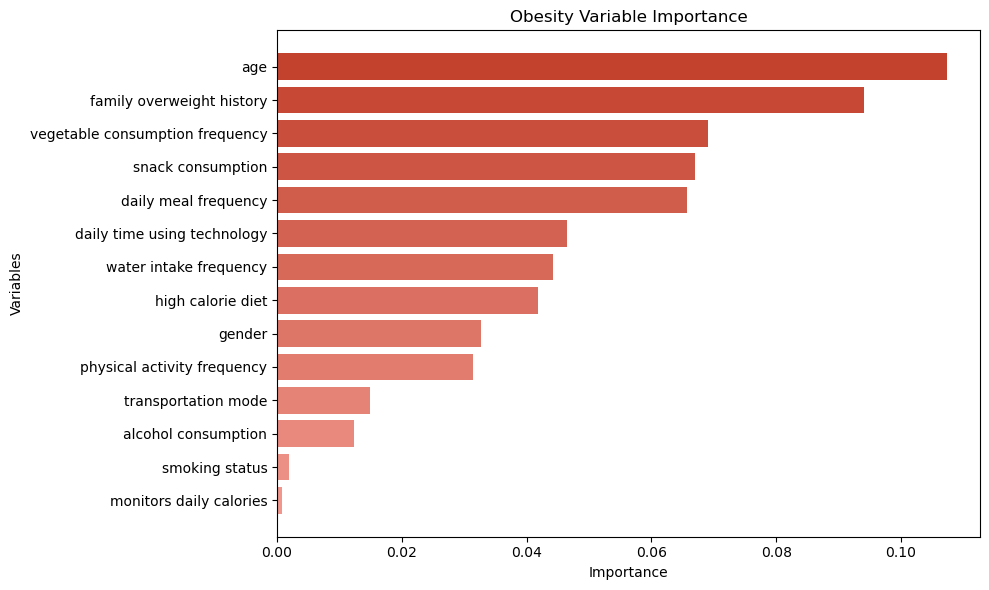

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data
feature_importances = pd.DataFrame({
    'feature': [
        'age', 'family_overweight_history', 'vegetable_consumption_frequency',
        'daily_meal_frequency', 'snack_consumption', 'daily_time_using_technology',
        'water_intake_frequency', 'high_calorie_diet', 'gender',
        'physical_activity_frequency', 'transportation_mode',
        'alcohol_consumption', 'smoking_status', 'monitors_daily_calories'
    ],
    'importance': [
        0.107310, 0.094068, 0.069083, 0.065728, 0.066986, 0.046495,
        0.044218, 0.041821, 0.032714, 0.031396, 0.014859, 0.012403,
        0.001857, 0.000719
    ]
})

# Sort descending
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Replace underscores with spaces for labels
variables = feature_importances['feature'].str.replace("_", " ", regex=False)
importances = feature_importances['importance']

base_color = np.array([194, 66, 46])/255  # #C2422E dark red
light_color = np.array([240, 150, 140])/255  # lighter red
num_bars = len(variables)
colors = [tuple(base_color + (light_color - base_color)*(i/(num_bars-1))) for i in range(num_bars)]

plt.figure(figsize=(10,6))
plt.barh(variables, importances, color=colors)
plt.gca().invert_yaxis()  # largest importance on top
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Obesity Variable Importance")
plt.tight_layout()
plt.show()
